In [ ]:
 import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.fashion_mnist import load_data
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Concatenate
 
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from keras.models import load_model
from matplotlib import pyplot

In [ ]:
#plt.imshow(Y_train[12000].reshape(28, 28))
#print(X_train[12000])

In [ ]:
def load_real_samples():
  # Load Data
  train = pd.read_csv("/content/drive/MyDrive/Thesis/Dataset/maleDigits.csv")

  # Separating Data and Label
  X_train = train["label"] -112
  Y_train = train.drop(labels = ["label"],axis = 1)

  #  Normalize the data
  Y_train = Y_train / 255.0

  # Reshape the array into 28 x 28 pixel
  Y_train = Y_train.values.reshape(-1,28,28,1)

  return [Y_train, X_train]

In [ ]:
def define_discriminator(in_shape=(28,28,1), n_classes=10):
	# label input
	in_label = Input(shape=(1,))
	# embedding for categorical input
	li = Embedding(n_classes, 50)(in_label)
	# scale up to image dimensions with linear activation
	n_nodes = in_shape[0] * in_shape[1]
	li = Dense(n_nodes)(li)
	# reshape to additional channel
	li = Reshape((in_shape[0], in_shape[1], 1))(li)
	# image input
	in_image = Input(shape=in_shape)
	# concat label as a channel
	merge = Concatenate()([in_image, li])
	# downsample
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(merge)
	fe = LeakyReLU(alpha=0.2)(fe)
	# downsample
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	# flatten feature maps
	fe = Flatten()(fe)
	# dropout
	fe = Dropout(0.4)(fe)
	# output
	out_layer = Dense(1, activation='sigmoid')(fe)
	# define model
	model = Model([in_image, in_label], out_layer)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

In [ ]:
def define_generator(latent_dim, n_classes=10):
	# label input
	in_label = Input(shape=(1,))
	# embedding for categorical input
	li = Embedding(n_classes, 50)(in_label)
	# linear multiplication
	n_nodes = 7 * 7
	li = Dense(n_nodes)(li)
	# reshape to additional channel
	li = Reshape((7, 7, 1))(li)
	# image generator input
	in_lat = Input(shape=(latent_dim,))
	# foundation for 7x7 image
	n_nodes = 128 * 7 * 7
	gen = Dense(n_nodes)(in_lat)
	gen = LeakyReLU(alpha=0.2)(gen)
	gen = Reshape((7, 7, 128))(gen)
	# merge image gen and label input
	merge = Concatenate()([gen, li])
	# upsample to 14x14
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge)
	gen = LeakyReLU(alpha=0.2)(gen)
	# upsample to 28x28
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
	gen = LeakyReLU(alpha=0.2)(gen)
	# output
	out_layer = Conv2D(1, (7,7), activation='tanh', padding='same')(gen)
	# define model
	model = Model([in_lat, in_label], out_layer)
	return model

In [ ]:
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# get noise and label inputs from generator model
	gen_noise, gen_label = g_model.input
	# get image output from the generator model
	gen_output = g_model.output
	# connect image output and label input from generator as inputs to discriminator
	gan_output = d_model([gen_output, gen_label])
	# define gan model as taking noise and label and outputting a classification
	model = Model([gen_noise, gen_label], gan_output)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

In [ ]:
def generate_real_samples(dataset, n_samples):
	# split into images and labels
	images, labels = dataset
	# choose random instances
	ix = randint(0, images.shape[0], n_samples)
	# select images and labels
	X, labels = images[ix], labels[ix]
	# generate class labels
	y = ones((n_samples, 1))
	return [X, labels], y

In [ ]:
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	# generate labels
	labels = randint(0, n_classes, n_samples)
	return [z_input, labels]

In [ ]:
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	z_input, labels_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	images = generator.predict([z_input, labels_input])
	# create class labels
	y = zeros((n_samples, 1))
	return [images, labels_input], y

In [ ]:
gloss = []
dloss1= []
dloss2= []
e= []

In [ ]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=1000, n_batch=128):
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
            # update discriminator model weights
            d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)
            # generate 'fake' examples
            [X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update discriminator model weights
            d_loss2, _ = d_model.train_on_batch([X_fake, labels], y_fake)
            # prepare points in latent space as input for the generator
            [z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
            gloss.append(g_loss)
            dloss1.append(d_loss1)
            dloss2.append(d_loss2)
            e.append(i+1)
            # summarize loss on this batch
            print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
                (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
        if(i%100==0):
            zx= i+1;
            g_name= '/content/drive/MyDrive/Thesis/Our trained model/1000 epoch/new/Epoch '+ str(zx)+'.h5'
            g_model.save(g_name, include_optimizer=True)
            d_name= '/content/drive/MyDrive/Thesis/Our trained model/1000 epoch/new/Epoch '+ str(zx)+'.h5'
            d_model.save(d_name, include_optimizer=True)
            gan_name= '/content/drive/MyDrive/Thesis/Our trained model/1000 epoch/new/Epoch '+ str(zx)+'.h5'
            gan_model.save(gan_name, include_optimizer=True)
    # save the generator model
    g_model.save('/content/drive/MyDrive/Thesis/Our trained model/10000 epoch/new/Epoch 1000')

In [ ]:
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
train(g_model, d_model, gan_model, dataset, latent_dim)

Streaming output truncated to the last 5000 lines.
>871, 21/118, d1=0.502, d2=0.367 g=1.908
>871, 22/118, d1=0.575, d2=0.353 g=1.749
>871, 23/118, d1=0.476, d2=0.350 g=2.045
>871, 24/118, d1=0.395, d2=0.507 g=1.762
>871, 25/118, d1=0.388, d2=0.364 g=2.046
>871, 26/118, d1=0.457, d2=0.449 g=2.015
>871, 27/118, d1=0.514, d2=0.445 g=1.995
>871, 28/118, d1=0.492, d2=0.314 g=2.072
>871, 29/118, d1=0.550, d2=0.448 g=1.719
>871, 30/118, d1=0.564, d2=0.352 g=1.938
>871, 31/118, d1=0.451, d2=0.430 g=1.834
>871, 32/118, d1=0.530, d2=0.325 g=2.004
>871, 33/118, d1=0.424, d2=0.465 g=1.682
>871, 34/118, d1=0.444, d2=0.357 g=2.027
>871, 35/118, d1=0.461, d2=0.599 g=1.909
>871, 36/118, d1=0.481, d2=0.336 g=2.237
>871, 37/118, d1=0.790, d2=0.396 g=1.684
>871, 38/118, d1=0.425, d2=0.482 g=1.768
>871, 39/118, d1=0.444, d2=0.292 g=2.167
>871, 40/118, d1=0.406, d2=0.634 g=1.928
>871, 41/118, d1=0.503, d2=0.446 g=2.091
>871, 42/118, d1=0.533, d2=0.304 g=2.163
>871, 43/118, d1=0.516, d2=0.512 g=1.763
>871, 

In [ ]:
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from keras.models import load_model
from matplotlib import pyplot

In [ ]:
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	# generate labels
	labels = randint(0, n_classes, n_samples)
	return [z_input, labels]

In [ ]:
def save_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
	pyplot.show()

In [ ]:
model = load_model('/content/drive/MyDrive/Thesis/Our trained model/cgan_generator.h5')

In [ ]:
history = load_model('/content/drive/MyDrive/Thesis/Our trained model/cgan_generator.h5')

In [ ]:
print(history.history.keys())

AttributeError: ignored

In [ ]:
def plot_graphs(history, string):
	plt.plot(history.history[string])
	plt.xlabel('Epochs')
	plt.ylabel(string)
	plt.show()
	
plot_graphs(history, 'loss')

TypeError: ignored

In [ ]:
a = [11,0,1]
labels= np.asarray(a)

In [ ]:
latent_dim =100
n_samples = labels.size

x_input = randn(latent_dim * n_samples)

latent_points = x_input.reshape(n_samples, latent_dim)

In [ ]:
X  = model.predict([latent_points, labels])

In [ ]:
for i in range(n_samples):
	pyplot.subplot(1,n_samples , i+1)
	pyplot.axis('off')
	pyplot.imshow(X[i].reshape(28,28), cmap='gray_r')

In [ ]:
for i in range n_samples :
	plt.imshow(X[i].reshape(28,28), cmap='gray_r')

In [ ]:
n= 10
pyplot.subplot(n, n, 10)
		# turn off axis
pyplot.axis('off')
		# plot raw pixel data
pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
pyplot.show()

In [ ]:
a = [3, 9]
labels= np.asarray(a)
labels

In [ ]:
X  = model.predict([latent_points, labels])

In [ ]:
latent_points, labels = generate_latent_points(100, 100)
latent_points


array([[-0.2638243 , -1.5015401 ,  0.15883815, ..., -0.40221857,
         1.8745896 ,  0.06108831],
       [ 1.53168749, -0.65826373, -0.31558931, ..., -0.14542664,
         0.32103918, -0.90229448],
       [-1.89628285,  1.10474258, -0.21441264, ..., -0.50171483,
        -1.52583782,  0.87260229],
       ...,
       [ 0.376885  , -0.09002491, -0.47184531, ...,  1.59411533,
         0.71878295,  1.39368881],
       [ 0.43568231, -0.03671614,  2.64625761, ...,  0.45890164,
         0.60045082, -0.7101243 ],
       [-0.84183843,  0.95610138,  0.52645249, ...,  1.32188157,
         0.10687108, -0.1632838 ]])

In [ ]:
labels = asarray([x for _ in range(10) for x in range(10)])
labels

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1,
       2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3,
       4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5,
       6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7,
       8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
X  = model.predict([latent_points, labels])

In [ ]:
X = (X + 1) / 2.0

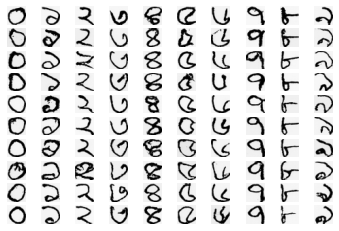

In [ ]:
save_plot(X, 10)